# TrICal Trapped Ion Calculator

This is a package for simulating a chain of trapped ions. The aim of this package is to remove the need for rewriting the same code to calculate equilibrium spacing, normal modes, and $J_{ij}$ every time a trap is being designed.

## Class Structure
![class structure](class_structure.png)

The basic form of the class structure is shown in the diagram. Typically in an ion trap there are three major terms in the potential; the DC part, the RF part and the coulomb part. In this code the user will input the DC and RF parts into the potential class. For the RF potential the pondermotive approximation will have to be taken before inputing the potential into the code. 

## Usage

The typical usage for this code will be to find the normal modes and frequencies for a given trap and for a given set of voltage applied to the trap electrodes. The potential around the centre of the trap is should be calculated via an appropriate method. The results of that calculation can then be input into the Potential class via three methods. The potential class is then used to calculate equilibrium spacing and normal modes. These are in turn fed into the SimulatedSpinLattice class to get out $J_{ij}$ coefficients.

In [15]:
import os
import sys

sys.path.append(os.path.abspath("../"))

import matplotlib
from matplotlib import cm
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import trical
from trical.misc.constants import m_a
from trical.misc.polynomial import multivariate_polyfit

In [2]:
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "sans"
matplotlib.rcParams["font.size"] = 15

## Potential Class
The potential class represents a potential applied to the trapped ion system. <br />
Requirements of the potential class are functions corresponding to:
$$
U,\frac{\partial U}{\partial a_i},\frac{\partial^2 U}{\partial a_i \partial b_j}  
$$

In [3]:
N = 3
dim = 3

def phi(x):
    x = np.array(x)
    return x.sum()


def dphi(var):
    def dphi_dai(x):
        return 1

    return dphi_dai


def d2phi(var1, var2):
    def d2phi_daidbj(x):
        return 0

    return d2phi_daidbj


U = trical.classes.Potential(phi, dphi, d2phi, N=N, dim=dim)

U_grad = U.gradient()
U_hess = U.hessian()

x = np.random.rand(N, dim)

print("Gradient of the potential:", U_grad(x))
print("Hessian of the potential:")
print(U_hess(x))

Gradient of the potential: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Hessian of the potential:
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### CoulombPotential Subclass

The CoulombPotential subclass of Potential represents the coulomb interaction between the ions in the trapped ion system.
$$
U(\{\vec{x}_n\}_n) = \sum_{i \neq j} \frac{q^2}{4 \pi \epsilon_0} \frac{1}{||\vec{x}_i - \vec{x}_j||_2}
$$

In [4]:
U_coulomb = trical.classes.CoulombPotential(N,dim=dim)

### PolynomialPotential Subclass

The PolynomialPotential approximates your trapping potential in the region around the ion chain with the following multivariate polynomial:
$$
    U \,(x,y,z) = \sum_{ijk} \alpha_{ijk}  x^iy^jz^k
$$


There are three ways to effectivly input the alpha values for your potential. To demonstrate all three methods the same trapping potential with $\omega_x = 2\pi\times6$MHz, $\omega_y = 2\pi\times5$MHz, and $\omega_z = 2\pi\times1$MHz will be entered via all three methods. This potential written in full is:
$$
    U(x, y, z) = \alpha_{2,0,0}x^2 + \alpha_{0,2,0}y^2 + \alpha_{0,0,2}z^2
$$



The first is to directly input the alpha values in a $N\times N \times N$ matrix. The matrix must be the same dimention in every axis. This is shown bellow where in the p matrix the index indicates the power in $x$, $y$, or $z$.

In [5]:
mass = m_a["Yb171"]
omega_x = 2 * np.pi * 2e7  # Hz
omega_y = 2 * np.pi * 1e7  # Hz
omega_z = 2 * np.pi * 1e6  # Hz

# Potential in Joules
alpha = np.zeros((3, 3, 3))
alpha[2, 0, 0] = mass * (omega_x) ** 2 / 2  # alpha_2,0,0
alpha[0, 2, 0] = mass * (omega_y) ** 2 / 2  # alpha_0,2,0
alpha[0, 0, 2] = mass * (omega_z) ** 2 / 2  # alpha_0,0,2

U_poly = trical.classes.PolynomialPotential(alpha)
print(alpha)

[[[0.00000000e+00 0.00000000e+00 5.60290428e-12]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [5.60290428e-10 0.00000000e+00 0.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[2.24116171e-09 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]]


#### Fitting to a PolynomialPotential
Finally the third method of defining a potential is to give a grid of points with the potential at each point. This grid will then be fit with polynomial and the coefficients of the polynomial will be returned in a format that can be submitted to the PolynomialPotential class via the first example method.

The format for submitting the grid to the fitting function is in two arrays. The first is a list of \[x,y,z\] positions, and the second is a list of the value of the potential at each point.

In [6]:
I_x = np.linspace(-2e-4, 2e-4, 81)
I_y = np.linspace(-2e-4, 2e-4, 81)
I_z = np.linspace(-5e-4, 5e-4, 201)

r = np.array(np.meshgrid(I_x, I_y, I_z))
r = r.reshape(3, -1).transpose()

f = lambda x, y, z: np.polynomial.polynomial.polyval3d(x, y, z, alpha)

U_r = f(*r.transpose())

l = 1e-6
deg = (2, 2, 2)
alpha_fit = multivariate_polyfit(r, U_r, deg)
print(alpha_fit)

U_polyfit = trical.classes.PolynomialPotential(alpha_fit)

[[[-1.31910810e-29  6.21748990e-25  5.60290428e-12]
  [ 2.49421172e-25  1.44099424e-25  1.32961206e-22]
  [ 5.60290428e-10 -1.73601203e-22  6.74034476e-18]]

 [[-7.23047099e-26 -2.06422326e-25 -8.48736698e-22]
  [-7.05547824e-25 -2.40858483e-21  1.27287429e-17]
  [-4.79328184e-21  2.61298968e-17  3.75087188e-18]]

 [[ 2.24116171e-09 -1.91024155e-21  9.24702272e-18]
  [-4.80063648e-20 -3.78806574e-18  1.47547951e-19]
  [ 5.88202548e-17 -4.93798168e-20 -7.64986819e-20]]]


### SymbolicPotential Subclass
The second method is to insert a symbolic expression using sympy for the potential. This is intended to be useful when you have an analyitical expression for your trapping potential. Using the same potential as the first example.

In [7]:
import sympy as sym

x, y, z = sym.symbols("x, y ,z")
expr = (
    mass * (omega_x) ** 2 / 2 * x ** 2
    + mass * (omega_y) ** 2 / 2 * y ** 2
    + mass * (omega_z) ** 2 / 2 * z ** 2
)
print(expr)

U_sym = trical.classes.SymbolicPotential(expr)

2.24116171324625e-9*x**2 + 5.60290428311563e-10*y**2 + 5.60290428311563e-12*z**2


## TrappedIons Class

This class calculates the equilibrium positions, normal modes, and frequencies of a given number of ions and trapping potential. The method of inputing the potential should not have any bearing on the equilibrum position. Using the equilibrium_position funciton we can see that all three input methods give the same positions in z.

In [14]:
ti_poly = trical.classes.TrappedIons(N, U_poly, m=mass)
ti_polyfit = trical.classes.TrappedIons(N, U_polyfit, m=mass)
ti_sym = trical.classes.TrappedIons(N, U_sym, m=mass)

ti_poly.equilibrium_position()
ti_polyfit.equilibrium_position()
ti_sym.equilibrium_position()

print("{:<26}:{}".format("PolynomialPotential", np.round(ti_poly.x_ep[:, 2] * 1e6, 5)))
print(
    "{:<26}:{}".format(
        "Fitted PolynomialPotential", np.round(ti_polyfit.x_ep[:, 2] * 1e6, 5)
    )
)
print("{:<26}:{}".format("SymbolicPotential", np.round(ti_sym.x_ep[:, 2] * 1e6, 5)))

PolynomialPotential       :[-2.95251 -0.       2.95251]
Fitted PolynomialPotential:[-2.95253 -0.       2.95253]
SymbolicPotential         :[-2.95253 -0.       2.95253]


In [9]:
ti_poly.normal_modes()
print("Normal mode frequencies:")
print(np.round(ti_poly.w,-5))
print("Normal mode eigenvectors:")
print(np.round(ti_poly.b,3))

ti_poly.principle_axis()
print("Principle axes:")
print(np.round(ti_poly.x_pa,3))
print("Normal mode frequencies:")
print(np.round(ti_poly.w_pa,-5))
print("Coordinate transformed normal mode eigenvectors:")
print(np.round(ti_poly.b_pa,3))

Normal mode frequencies:
[1.257e+08 1.255e+08 1.253e+08 6.280e+07 6.250e+07 6.210e+07 1.510e+07
 1.090e+07 6.300e+06]
Normal mode eigenvectors:
[[ 0.577 -0.707  0.408 -0.    -0.    -0.     0.     0.     0.   ]
 [ 0.577  0.    -0.816  0.     0.     0.    -0.    -0.    -0.   ]
 [ 0.577  0.707  0.408 -0.    -0.    -0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.577  0.707  0.408  0.     0.    -0.   ]
 [-0.    -0.    -0.     0.577 -0.    -0.816 -0.    -0.     0.   ]
 [ 0.     0.     0.     0.577 -0.707  0.408 -0.     0.     0.   ]
 [-0.    -0.    -0.     0.    -0.    -0.     0.408  0.707  0.577]
 [ 0.     0.     0.     0.    -0.    -0.    -0.816 -0.     0.577]
 [ 0.     0.     0.     0.    -0.    -0.     0.408 -0.707  0.577]]
Principle axes:
[[ 1.  0. -0.]
 [-0.  1.  0.]
 [ 0.  0.  1.]]
Normal mode frequencies:
[1.257e+08 1.255e+08 1.253e+08 6.280e+07 6.250e+07 6.210e+07 1.510e+07
 1.090e+07 6.300e+06]
Coordinate transformed normal mode eigenvectors:
[[ 0.577 -0.707  0.408 -0.     0

## SimulatedSpinLattice 

This class takes in a TrappedIons class and using the eigen frequencies produces a Jij coupling matrix along some axis with the axis, wavelength, detuning and adressing being input parameters.


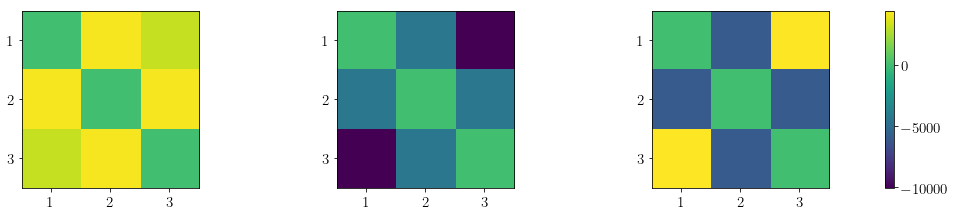

In [10]:
wavelength = 355e-9

detuning = 2 * np.pi * 1e4
mu = np.array([np.array([ti_poly.w_pa[:N][i] + detuning]) for i in range(N)])
omega = np.full((N, 1), 1e6)

ssl = [
    trical.classes.SimulatedSpinLattice(ti_poly, mu[i], omega, k=2 * np.pi / wavelength)
    for i in range(N)
]

J = np.array([ssl[i].J for i in range(N)])

norm = matplotlib.colors.Normalize(J.min(), J.max())
sm = cm.ScalarMappable(norm, cmap=cm.viridis)
sm.set_array(J)

fig = plt.figure(figsize=(20, 15))
ax = [fig.add_subplot(4, 3, i + 1) for i in range(N)]
for i in range(N):
    im = ax[i].imshow(J[i], cmap=cm.viridis, norm=norm)
    ax[i].set_xticks(np.arange(N))
    ax[i].set_yticks(np.arange(N))
    ax[i].set_xticklabels(np.arange(N) + 1)
    ax[i].set_yticklabels(np.arange(N) + 1)
fig.colorbar(sm, ax=ax)